In [17]:
import numpy as np
import torch
import torch.nn as nn
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

def clear_diagonals(matrix, lower=3, upper=3):
    n_rows, n_cols = matrix.shape
    for k in range(-lower, upper + 1):
        start_row = max(0, -k)
        start_col = max(0, k)
        sub_matrix = matrix[start_row:, start_col:]
        np.fill_diagonal(sub_matrix, 0)
    return matrix

def get_hic_matrix_from_juicer(intval, hicfn, resolution):
    import hicstraw
    chr, start, end = intval
    hic = hicstraw.HiCFile(hicfn)
    mzd = hic.getMatrixZoomData(chr, chr, "observed", "NONE", "BP", resolution)
    numpy_matrix = mzd.getRecordsAsMatrix(start, end, start , end)
    return numpy_matrix

def get_hic_matrix_from_cooler(intval, hicfn, resolution):
    import cooler
    chr, start, end = intval
    clr = cooler.Cooler(f'{hicfn}::/resolutions/{resolution}')
    numpy_matrix = clr.matrix(balance=False).fetch(intval)
    return numpy_matrix

import torch
import torch.nn as nn
import numpy as np

def resize_matrix(matrix, target_rows, target_cols, upsampling_method='bilinear'):
    """
    Resize any 2D matrix to target dimensions while preserving information
    
    Parameters:
        matrix (np.ndarray): Input 2D array
        target_rows (int): Desired number of rows
        target_cols (int): Desired number of columns
        upsampling_method (str): Method for upsampling when input is smaller than target
            Options: 'conv_transpose', 'bilinear', 'pixel_shuffle', 'adaptive'
    
    Returns:
        np.ndarray: Resized matrix of shape (target_rows, target_cols)
    """
    with torch.no_grad():
        # Validate inputs
        if not isinstance(matrix, np.ndarray) or matrix.ndim != 2:
            raise ValueError("Input must be a 2D numpy array")
        if target_rows <= 0 or target_cols <= 0:
            raise ValueError("Target dimensions must be positive integers")
        
        h, w = matrix.shape
        matrix = matrix.copy().astype(np.float32)
        
        if h == target_rows and w == target_cols:
            return matrix
        
        # Process dimensions separately
        resized_h = _resize_dim(matrix, dim=0, target_size=target_rows)
        final_resized = _resize_dim(resized_h, dim=1, target_size=target_cols,
                                   upsampling_method=upsampling_method)
        return final_resized

def _resize_dim(matrix, dim, target_size, upsampling_method='bilinear'):
    """Resize a single dimension (height=0 or width=1)"""
    with torch.no_grad():
        current_size = matrix.shape[dim]
        if current_size == target_size:
            return matrix
        
        if current_size > target_size:
            return _downsample_dim(matrix, dim, target_size)
        else:
            return _upsample_dim(matrix, dim, target_size, upsampling_method)

def _downsample_dim(matrix, dim, target_size):
    """Downsample one dimension using average pooling"""
    with torch.no_grad():
        current_size = matrix.shape[dim]
        kernel_size = current_size - target_size + 1
        
        # Create appropriate kernel
        if dim == 0:
            kernel = (kernel_size, 1)
        else:
            kernel = (1, kernel_size)
        
        conv = nn.Conv2d(1, 1, kernel_size=kernel, stride=1, padding=0, bias=False)
        conv.weight.data = torch.ones_like(conv.weight) / (kernel_size)
        
        input_tensor = torch.tensor(matrix).unsqueeze(0).unsqueeze(0).float()
        result = conv(input_tensor)
        return result.squeeze().detach().numpy()

def _upsample_dim(matrix, dim, target_size, method):
    """Upsample one dimension using specified method"""
    with torch.no_grad():
        current_size = matrix.shape[dim]
        input_tensor = torch.tensor(matrix).unsqueeze(0).unsqueeze(0).float()
        
        if method == 'conv_transpose':
            kernel_size = target_size - current_size + 1
            conv_trans = nn.ConvTranspose2d(1, 1, 
                kernel_size=(kernel_size, 1) if dim == 0 else (1, kernel_size),
                stride=1, padding=0, bias=False)
            weight = torch.zeros_like(conv_trans.weight)
            center = kernel_size // 2
            if dim == 0:
                weight[0, 0, center, 0] = 1.0
            else:
                weight[0, 0, 0, center] = 1.0
            conv_trans.weight.data = weight
            result = conv_trans(input_tensor)
            return result.squeeze().detach().numpy()
        
        elif method == 'bilinear':
            h, w = matrix.shape
            target_shape = (target_size, w) if dim == 0 else (h, target_size)
            upsampler = nn.Upsample(size=target_shape, mode='bilinear', align_corners=True)
            return upsampler(input_tensor).squeeze().detach().numpy()
        
        elif method == 'pixel_shuffle':
            scale_factor = target_size // current_size
            if target_size % current_size != 0:
                raise ValueError(f"Pixel shuffle requires target size ({target_size}) "
                                 f"to be multiple of current size ({current_size})")
            
            input_channels = scale_factor ** 2
            ps = nn.PixelShuffle(scale_factor)
            input_expanded = input_tensor.repeat(1, input_channels, 1, 1)
            return ps(input_expanded).squeeze().detach().numpy()
        
        elif method == 'adaptive':
            target_shape = (target_size, matrix.shape[1]) if dim == 0 else (matrix.shape[0], target_size)
            pool = nn.AdaptiveAvgPool2d(target_shape)
            return pool(input_tensor).squeeze().detach().numpy()
        
        else:
            raise ValueError(f"Unknown upsampling method: {method}")


def parse_arguments():
    parser = argparse.ArgumentParser(description="Process ACA and Hi-C files.")
    parser.add_argument("acafn", type=str, help="Path to ACA format bed file")
    parser.add_argument("hicfn", type=str, help="Path to input the hic file")
    parser.add_argument("--resolution", type=int, default=500, help="Resolution of Hi-C data")
    parser.add_argument("--pad", type=int, default=1, help="Length outside the interval square")
    parser.add_argument("--diag_ignore", type=int, default=0, help="Pixels close to diagonal to be set to 0")
    parser.add_argument("--scale_factor", type=float, default=1.0, help="Normalization scale factor")
    parser.add_argument("--cols_per_interval", type=int, default=15, help="Number of target matrix columns for one interval")
    return parser.parse_args()


def process_acafn(acafn, hicfn, resolution, pad, diag_ignore, scale_factor, cols_per_interval):
    with open(acafn, 'r') as f:
        lines = f.readlines()

    matrices = []
    for line in lines:
        intervals = line.strip().split('\t')
        n = len(intervals) // 3
        intervals = [(intervals[i], int(intervals[i+1]), int(intervals[i+2])) for i in range(0, len(intervals), 3)]
        intervals.sort(key=lambda x: x[1])
        
        internal_len = max([x[2] for x in intervals]) - min([x[1] for x in intervals]) + 1
        unit_len = int(internal_len / n)
        unit_len = math.ceil(unit_len/resolution) * resolution
        total_start = min([x[1] for x in intervals]) - pad * unit_len
        total_end = max([x[2] for x in intervals]) + pad * unit_len
        
        if hicfn.split(".")[-1] == "hic":
            hic_matrix = get_hic_matrix_from_juicer((intervals[0][0], total_start, total_end), hicfn, resolution)
        else:
            hic_matrix = get_hic_matrix_from_cooler((intervals[0][0], total_start, total_end), hicfn, resolution)
        
        if diag_ignore > 0:
            # for i in range(-diag_ignore, diag_ignore + 1):
            #     np.fill_diagonal(np.roll(hic_matrix, i, axis=0), 0)
            #     np.fill_diagonal(np.roll(hic_matrix, i, axis=1), 0)
            clear_diagonals(hic_matrix, diag_ignore, diag_ignore)
        
        tmp_interval_starts = [int((intervals[i][1])/resolution) for i in range(n)]
        cut_points = np.array([int(total_start/resolution)] + tmp_interval_starts)
        #cut_points = cut_points[1:] - cut_points[:-1]
        #cut_points = [int((intervals[i][1] - resolution)/resolution) for i in range(n)]
        cut_points = cut_points - cut_points[0]
        cut_points = np.concatenate((cut_points, [hic_matrix.shape[0]]))
        
        sub_matrices = []
        for i in range(len(cut_points) - 1):
            for j in range(len(cut_points) - 1):
                sub_matrix = hic_matrix[cut_points[i]:cut_points[i+1], cut_points[j]:cut_points[j+1]]
                resized_matrix = resize_matrix(sub_matrix, cols_per_interval, cols_per_interval)
                sub_matrices.append(resized_matrix)
        
        combined_matrix = np.block([[sub_matrices[i * (n+1) + j] for j in range(n+1)] for i in range(n+1)])
        matrices.append(combined_matrix)
    
    averaged_matrix = np.mean(matrices, axis=0) * scale_factor
    return averaged_matrix

In [42]:
def plot_aca_matrix(averaged_matrix, cols_per_interval, nnode, save_fig_fn):
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['font.size'] = 16
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(averaged_matrix, cmap='viridis')
    plt.title(f'Aggregated TRIP signal for the {nnode}-node cliques')

    # Set specific x and y tick positions and labels
    pos = np.arange(0, averaged_matrix.shape[0], cols_per_interval)[1:]
    label = np.arange(nnode) + 1
    ax.set_xticks(pos)               # Tick positions on x-axis
    ax.set_xticklabels(label, rotation=0)    # Labels for these positions

    ax.set_yticks(pos)               # Tick positions on y-axis
    ax.set_yticklabels(label)    # Labels for these positions
    plt.savefig(save_fig_fn)
    plt.show()

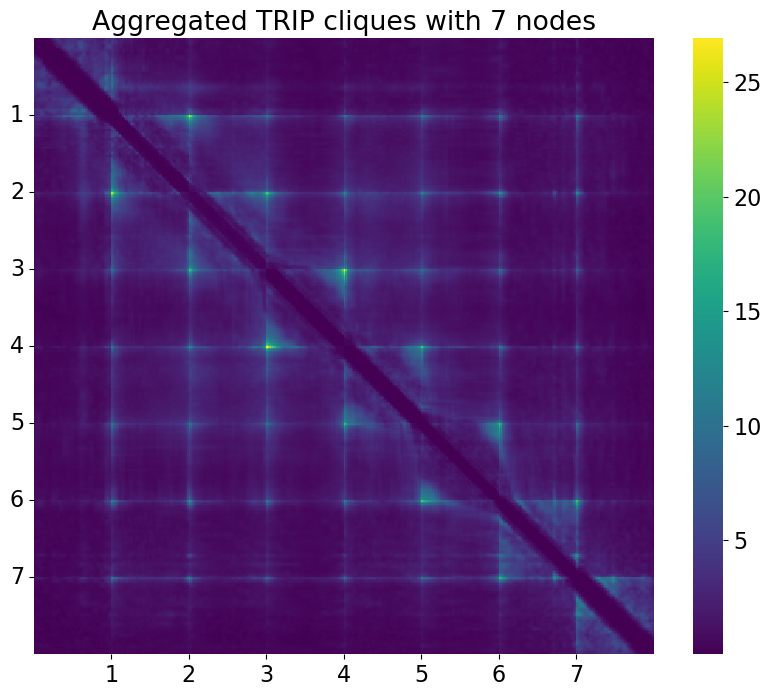

In [40]:
import sys
nnode = 7
sys.argv = ["script_name.py", "--diag_ignore", "5", "--cols_per_interval", "50", f"/mirror/Data/Gengyao_Chen/TRIP_article_figures/PE_network/network_properties/Data/cliques/clique_{nnode}.aca", "/STORE3/TRIP/24-10-15_H3K27ac/results/distiller/distiller_outputs/coolers_library/TRIP_H3K27ac2_pooled_967M.hg19.mapq_30.125.mcool"]

args = parse_arguments()
first_line = open(args.acafn).readline().strip()
first_intervals = first_line.strip().split('\t')
nnode = len(first_intervals) // 3

mat = process_acafn(args.acafn, args.hicfn, args.resolution, args.pad, args.diag_ignore, args.scale_factor, args.cols_per_interval)

figroot = "/mirror/Data/Gengyao_Chen/TRIP_article_figures/PE_network/network_properties/Figures"
plot_aca_matrix(mat, args.cols_per_interval, nnode, f"{figroot}/25-03-18_aca_clique_{nnode}.tiff")

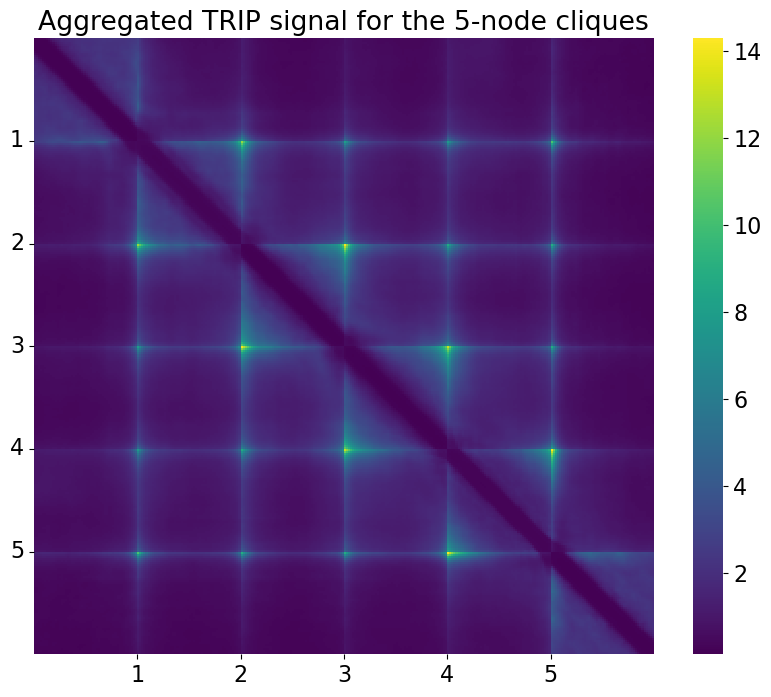

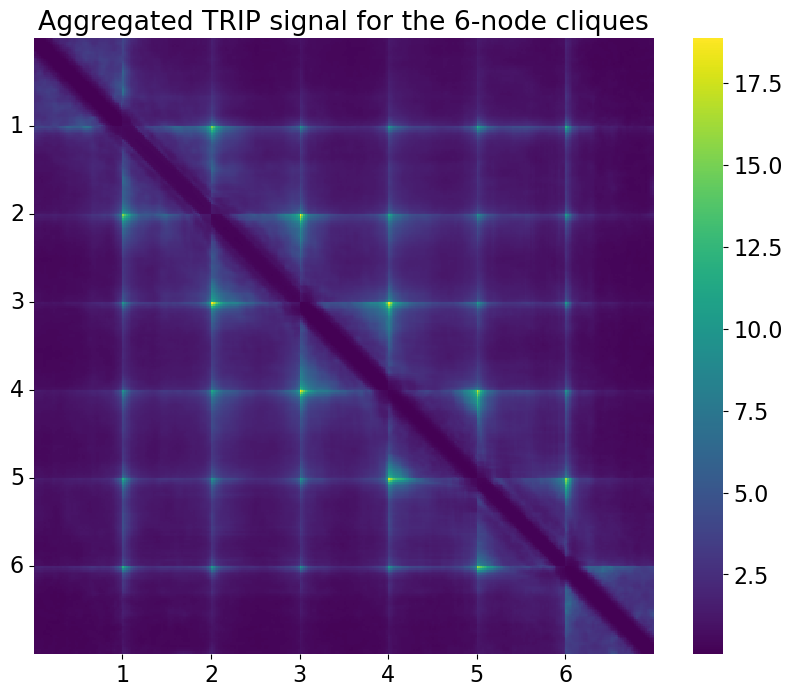

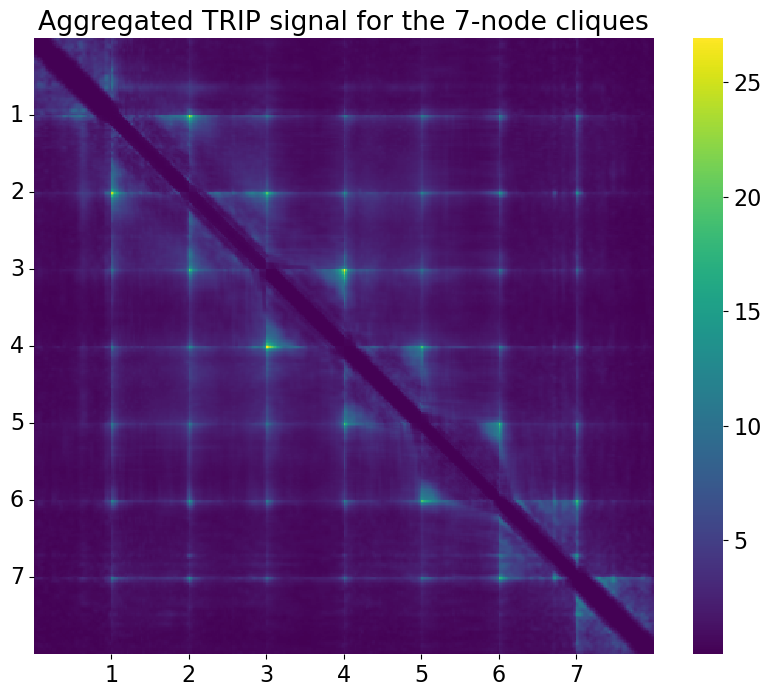

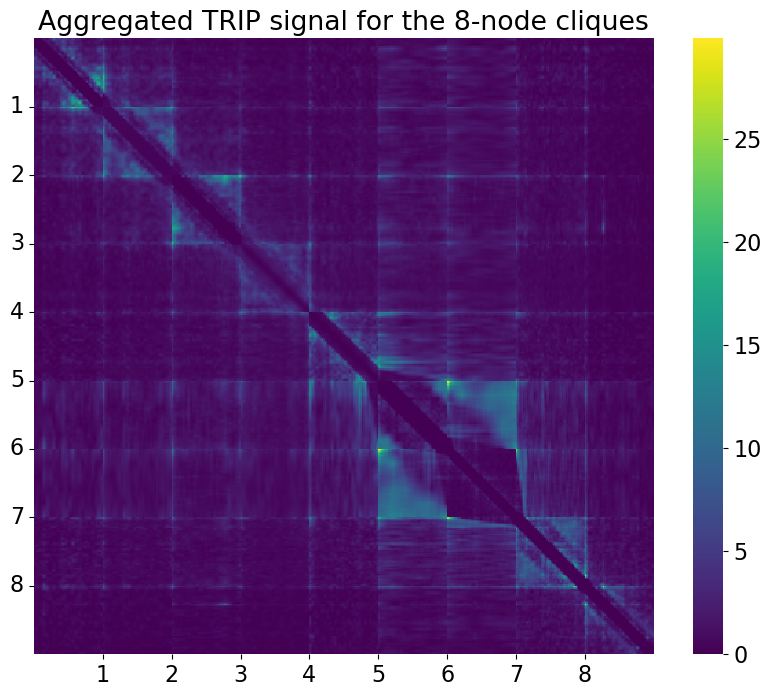

In [44]:
import sys

for i in range(5, 9):
    nnode = i
    sys.argv = ["script_name.py", "--diag_ignore", "5", "--cols_per_interval", "50", f"/mirror/Data/Gengyao_Chen/TRIP_article_figures/PE_network/network_properties/Data/cliques/clique_{nnode}.aca", "/STORE3/TRIP/24-10-15_H3K27ac/results/distiller/distiller_outputs/coolers_library/TRIP_H3K27ac2_pooled_967M.hg19.mapq_30.125.mcool"]

    args = parse_arguments()
    first_line = open(args.acafn).readline().strip()
    first_intervals = first_line.strip().split('\t')
    nnode = len(first_intervals) // 3

    mat = process_acafn(args.acafn, args.hicfn, args.resolution, args.pad, args.diag_ignore, args.scale_factor, args.cols_per_interval)

    figroot = "/mirror/Data/Gengyao_Chen/TRIP_article_figures/PE_network/network_properties/Figures"
    plot_aca_matrix(mat, args.cols_per_interval, nnode, f"{figroot}/25-03-18_aca_clique_{nnode}.tiff")


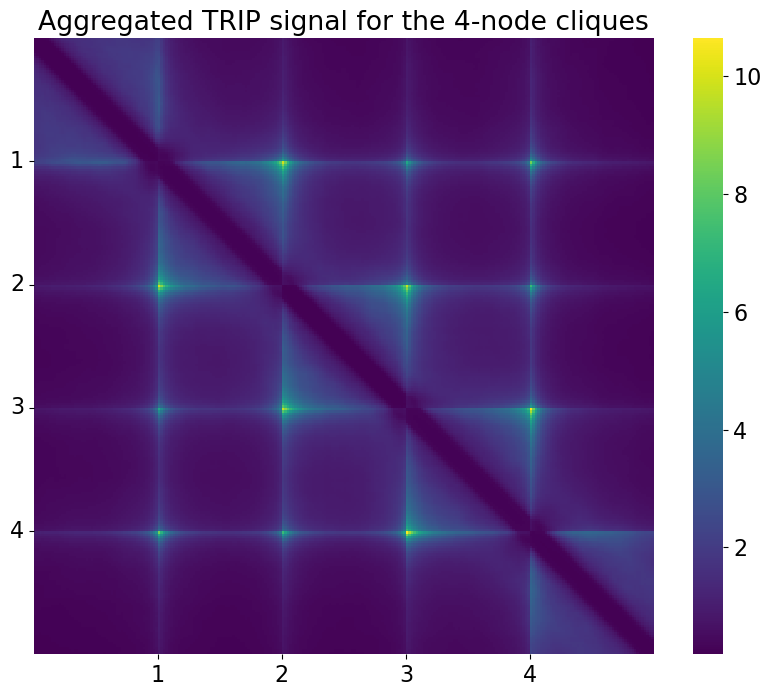

In [45]:
import sys

for i in range(4, 5):
    nnode = i
    sys.argv = ["script_name.py", "--diag_ignore", "5", "--cols_per_interval", "50", f"/mirror/Data/Gengyao_Chen/TRIP_article_figures/PE_network/network_properties/Data/cliques/clique_{nnode}.aca", "/STORE3/TRIP/24-10-15_H3K27ac/results/distiller/distiller_outputs/coolers_library/TRIP_H3K27ac2_pooled_967M.hg19.mapq_30.125.mcool"]

    args = parse_arguments()
    first_line = open(args.acafn).readline().strip()
    first_intervals = first_line.strip().split('\t')
    nnode = len(first_intervals) // 3

    mat = process_acafn(args.acafn, args.hicfn, args.resolution, args.pad, args.diag_ignore, args.scale_factor, args.cols_per_interval)

    figroot = "/mirror/Data/Gengyao_Chen/TRIP_article_figures/PE_network/network_properties/Figures"
    plot_aca_matrix(mat, args.cols_per_interval, nnode, f"{figroot}/25-03-18_aca_clique_{nnode}.tiff")

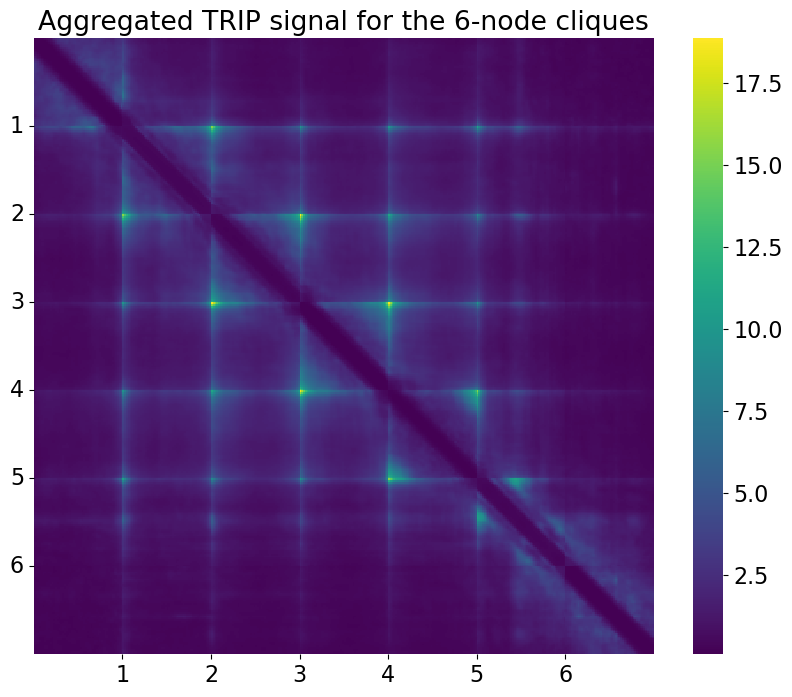

In [47]:
import sys
sys.argv = ["script_name.py", "--diag_ignore", "5", "--cols_per_interval", "50", f"/mirror/Data/Gengyao_Chen/TRIP_article_figures/PE_network/network_properties/Data/tmp/cli6_control.aca", "/STORE3/TRIP/24-10-15_H3K27ac/results/distiller/distiller_outputs/coolers_library/TRIP_H3K27ac2_pooled_967M.hg19.mapq_30.125.mcool"]

args = parse_arguments()
first_line = open(args.acafn).readline().strip()
first_intervals = first_line.strip().split('\t')
nnode = len(first_intervals) // 3

mat = process_acafn(args.acafn, args.hicfn, args.resolution, args.pad, args.diag_ignore, args.scale_factor, args.cols_per_interval)

plot_aca_matrix(mat, args.cols_per_interval, nnode, f"/mirror/Data/Gengyao_Chen/TRIP_article_figures/PE_network/network_properties/Data/tmp/figures/25-03-18_aca_clique_6_control.tiff")

In [23]:
import sys
sys.argv = ["script_name.py", "--diag_ignore", "5", "--cols_per_interval", "50","/mirror/Data/Gengyao_Chen/TRIP_article_figures/PE_network/network_properties/Data/cliques/clique_7.aca", "/STORE3/TRIP/24-10-15_H3K27ac/results/distiller/distiller_outputs/coolers_library/TRIP_H3K27ac2_pooled_967M.hg19.mapq_30.125.mcool"]

if __name__ == "__main__":
    args = parse_arguments()
    mat = process_acafn(args.acafn, args.hicfn, args.resolution, args.pad, args.diag_ignore, args.scale_factor, args.cols_per_interval)